In [2]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Get the current working directory
script_dir = os.getcwd()

# File paths
input_file_path = os.path.join(script_dir, 'fifa23_official_data.csv')
output_file_path = os.path.join(script_dir, 'fifa23_official_data_preprocessed.csv')

# CHunks (processing in smaller parts)
chunk_size = 1000
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()

header_saved = False

# Function to convert currency strings to numeric
def convert_currency(value):
    if isinstance(value, str):
        value = ''.join(filter(lambda x: x.isdigit() or x in ['M', 'K', '.', ' '], value)).strip()  # Keep only digits, M, K, and decimal
        if value.endswith('M'):
            return float(value[:-1].replace(' ', '')) * 1_000_000  # Remove 'M' and convert to millions
        elif value.endswith('K'):
            return float(value[:-1].replace(' ', '')) * 1_000  # Remove 'K' and convert to thousands
        else:
            try:
                return float(value)  # Convert to float if it's a normal number
            except ValueError:
                return 0.0  # Return 0 if conversion fails
    return 0.0  # Return 0 if the value is not a string

# Function to convert height and weight strings to integer
def convert_height_weight(value):
    if isinstance(value, str):
        return int(value.replace('cm', '').strip())  # Remove 'cm' and convert to int
    return 0  # Return 0 if the value is not a string

# Processing chunks
for chunk in pd.read_csv(input_file_path, chunksize=chunk_size):

    # Drop missing values
    chunk = chunk.dropna(axis=1, how='all')

    # Exclude columns 
    columns_to_exclude = ['ID', 'Age', 'Kit Number', 'Special']

    num_cols = chunk.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)
    cat_cols = chunk.select_dtypes(include=['object']).columns.difference(columns_to_exclude)

    # Fill missing values
    chunk[num_cols] = num_imputer.fit_transform(chunk[num_cols])
    chunk[cat_cols] = cat_imputer.fit_transform(chunk[cat_cols])

    # Convert the 'Value', 'Wage', and 'Release Clause' columns to numeric
    for col in ['Value', 'Wage', 'Release Clause']:
        if col in chunk.columns:
            chunk[col] = chunk[col].apply(convert_currency)

    # Convert 'Height' and 'Weight' columns to numeric
    if 'Height' in chunk.columns:
        chunk['Height'] = chunk['Height'].apply(convert_height_weight)

    if 'Weight' in chunk.columns:
        chunk['Weight'] = chunk['Weight'].apply(lambda x: int(x.replace('kg', '').strip()) if isinstance(x, str) else 0)

    # Encode Preferred Foot to binary (Right = 1, Left = 0)
    if 'Preferred Foot' in chunk.columns:
        chunk['Preferred Foot'] = chunk['Preferred Foot'].map({'Right': 1, 'Left': 0}).fillna(0).astype(int)

    # Clean and map the Position feature to numeric
    if 'Position' in chunk.columns:
        # Remove tags and keep alphanumeric characters only
        chunk['Position'] = chunk['Position'].str.extract(r'>(\w+)', expand=False).str.strip()

        # Mapping dictionary
        position_mapping = {
            'SUB': 0, 'LCM': 1, 'LB': 2, 'RCM': 3, 'RDM': 4, 'LCB': 5, 'RB': 6,
            'LM': 7, 'RS': 8, 'ST': 9, 'GK': 10, 'RW': 11, 'CF': 12, 'LW': 13,
            'CAM': 14, 'CDM': 15, 'CB': 16, 'RWB': 17, 'LWB': 18, 'RAM': 19, 'LAM': 20
        }

        # Apply the mapping
        chunk['Position'] = chunk['Position'].map(position_mapping).fillna(99).astype(int)

    # Encode Work Rate into a single numerical column
    if 'Work Rate' in chunk.columns:
        work_rate_full_map = {
            'High/ High': 3, 'High/ Medium': 2.5, 'Medium/ High': 2.5, 'Medium/ Medium': 2,
            'High/ Low': 2, 'Low/ High': 2, 'Medium/ Low': 1.5, 'Low/ Medium': 1.5, 'Low/ Low': 1
        }
        chunk['Work Rate Encoded'] = chunk['Work Rate'].map(work_rate_full_map).fillna(2).astype(float)


    # Scale numerical columns
    chunk[num_cols] = scaler.fit_transform(chunk[num_cols])

    # Save preprocessed chunk
    chunk.to_csv(output_file_path, mode='a', index=False, header=not header_saved)
    header_saved = True

print("Preprocessing complete. Data saved to:", output_file_path)


Preprocessing complete. Data saved to: E:\file_main\file_dataset\fifa23_official_data_preprocessed.csv


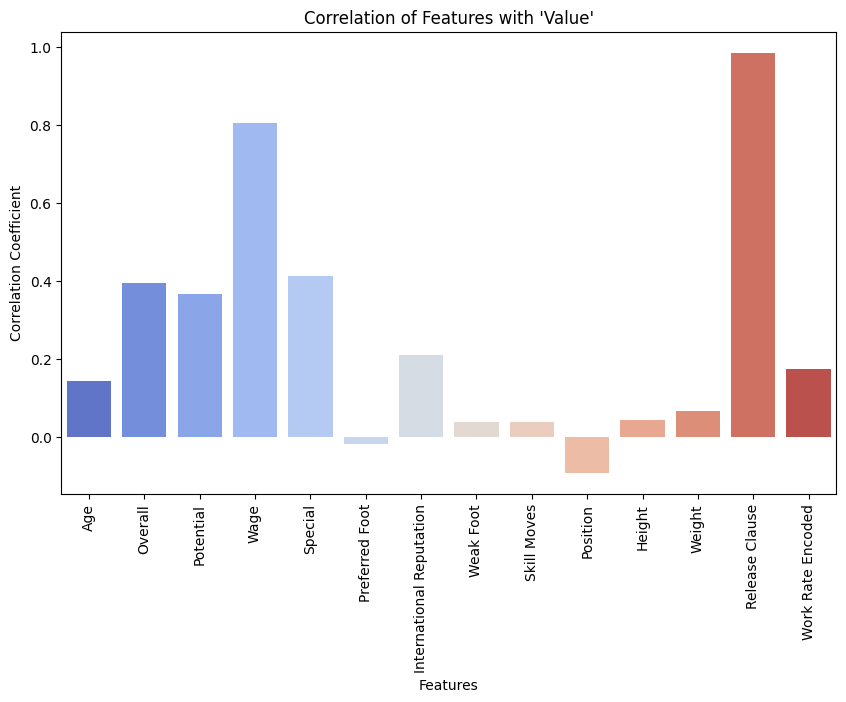

Correlation of 'Value' with other features:
                              Value
Release Clause            0.985096
Wage                      0.805169
Special                   0.413166
Overall                   0.394962
Potential                 0.365610
International Reputation  0.210941
Work Rate Encoded         0.174788
Age                       0.142080
Weight                    0.066839
Height                    0.042242
Skill Moves               0.038967
Weak Foot                 0.038774
Preferred Foot           -0.018166
Position                 -0.091909


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed data from the saved CSV and skip problematic rows
df = pd.read_csv(r'E:\file_main\file_dataset\fifa23_official_data_preprocessed.csv', on_bad_lines='skip')

# Select only numerical columns and drop 'ID' and 'Kit Number'
df_numeric = df.select_dtypes(include=['float64', 'int64']).copy()
df_numeric = df_numeric.drop(columns=['ID', 'Kit Number'], errors='ignore')  # Remove 'ID' and 'Kit Number'

# Check if 'Value' exists in the data
if 'Value' not in df_numeric.columns:
    print("'Value' column is missing from the dataset.")
else:
    # Calculate the correlation matrix
    correlation_matrix = df_numeric.corr()

    # Focus on the correlation between 'Value' and all other features
    value_correlations = correlation_matrix[['Value']].drop('Value')

    # Visualize the correlation between 'Value' and other features as a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_correlations.index, y=value_correlations['Value'], hue=value_correlations.index, palette='coolwarm', dodge=False, legend=False)
    plt.xticks(rotation=90)
    plt.title("Correlation of Features with 'Value'")
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Features")
    plt.show()

    # Display the correlation values in tabular form
    print("Correlation of 'Value' with other features:\n", value_correlations.sort_values(by='Value', ascending=False))


In [4]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Load the preprocessed data from the saved CSV and skip problematic rows
df = pd.read_csv(r'E:\file_main\file_dataset\fifa23_official_data_preprocessed.csv', on_bad_lines='skip')

# Select numerical columns, drop 'ID', 'Kit Number', and 'Value' for VIF calculation
df_numeric = df.select_dtypes(include=['float64', 'int64']).copy()
df_numeric = df_numeric.drop(columns=['ID', 'Kit Number', 'Value'], errors='ignore')

# Standardize the data (VIF works best when data is standardized)
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Function to calculate VIF for each feature
def calculate_vif(data):
    vif = pd.DataFrame()
    vif["Feature"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

# Calculate VIF for each feature
vif_df = calculate_vif(df_numeric_scaled)

# Display the VIF values
print("VIF values for each feature:\n", vif_df)


VIF values for each feature:
                      Feature       VIF
0                        Age  4.005580
1                    Overall  3.093352
2                  Potential  3.774484
3                       Wage  3.079686
4                    Special  2.531939
5             Preferred Foot  1.038043
6   International Reputation  1.379101
7                  Weak Foot  1.055061
8                Skill Moves  1.094718
9                   Position  1.094379
10                    Height  2.567800
11                    Weight  2.491303
12            Release Clause  2.970812
13         Work Rate Encoded  1.138210


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


X = df.drop('Value', axis=1)  # Features (all columns except the target 'Value')
y = df['Value']  # Target column 'Value' (the one you're predicting)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)


Training features shape: (8528, 23)
Testing features shape: (2132, 23)
Training target shape: (8528,)
Testing target shape: (2132,)


In [6]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv(r'E:\file_main\file_dataset\fifa23_official_data_preprocessed.csv', on_bad_lines='skip')

# Exclude non-numerical and irrelevant columns
irrelevant_columns = ['ID', 'Name', 'Nationality', 'Club', 'Special', 'Real Face', 'Joined', 'Contract Valid Until']
numerical_columns = [col for col in df.columns if col not in irrelevant_columns and df[col].dtype in ['float64', 'int64']]

# Define features (X) and target variable (y)
X = df[numerical_columns].drop('Value', axis=1, errors='ignore')  # Features (excluding 'Value')
y = df['Value']  # Target column (the one you're predicting)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Save the testing set predictions into a CSV file
# Create a DataFrame with test features, actual values, and predictions
test_results = X_test.copy()
test_results['Actual Value'] = y_test.values  # Include actual target values
test_results['Predicted Value'] = y_pred     # Include predicted target values

# Save the results to a CSV file
test_results.to_csv('test_predictions.csv', index=False)

print("Test predictions saved to 'test_predictions.csv'.")

Training features shape: (8528, 13)
Testing features shape: (2132, 13)
Training target shape: (8528,)
Testing target shape: (2132,)
Mean Absolute Error (MAE): 403802.9502814259
Root Mean Squared Error (RMSE): 1129709.4556379677
R² Score: 0.9864673220059509
Test predictions saved to 'test_predictions.csv'.


D:\Python\3.11\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
